In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
import scipy
from scipy.signal import savgol_filter
import xarray
from tqdm import tqdm
import rasterio as rio
import affine
import os
import elevation
import imageio.v2 as imageio
from matplotlib.colors import BoundaryNorm
import geopandas as gpd
from pyproj import Transformer
import matplotlib.colors as mcolors
from scipy.integrate import cumulative_trapezoid

In [2]:
# load centerline

points = pd.read_csv('centerline_points_100m.csv')
x, y =points.X.to_numpy(), points.Y.to_numpy()

# Reverse the arrays using slicing
x = x[::-1]
y = y[::-1]

#distance from terminus along centerline 
d = np.linspace(0, 100*len(x), len(x))
print('finished loading centerlines')

finished loading centerlines


In [3]:
# load DEM    
# Open the GeoTIFF file
with rio.open('ifsar_hubbardDEM_reproj.tif') as src:
    # Convert centerline coordinates to pixel indices
    i, j = rio.transform.rowcol(src.transform, x, y)

    # Read the raster data
    data = src.read(1)  # Assuming a single band image
    
    surfdem_centerline = data[i, j]

print('finished calculating dem and slope along centerline')

finished calculating dem and slope along centerline


In [4]:
# load DEM    

with rio.open('hubbard_bedrock_icebridge_reproj.tif') as src:
    # Convert centerline coordinates to pixel indices
    i, j = rio.transform.rowcol(src.transform, x, y)

    # Read the raster data
    data = src.read(1)  # Assuming a single band image
    
    beddem_centerline = data[i, j]

# n = 5
# beddem_centerline = np.convolve(np.ones(n)/n, beddem_centerline, mode="same")
# surfdem_centerline = np.convolve(np.ones(n)/n, surfdem_centerline, mode="same")
print('finished calculating bed dem along centerline')

finished calculating bed dem along centerline


In [77]:
# velocity along centerline at a particular time

hubv = xarray.open_dataset("../Hubbard_5eminus5.nc")

year = 2016
ns_in_day = 60 * 60 * 24 * 1e9
epoch = np.datetime64("%s-01-01" % year)
t = ((hubv.time[:] - epoch).to_numpy() / ns_in_day).astype(np.float32)

# Convert time values to datetime objects
datetime_index = pd.to_datetime(hubv.time.values)

# time series for each point
vx = np.zeros((x.shape[0], hubv.vx.shape[0]))
vy = np.zeros((x.shape[0], hubv.vx.shape[0]))
v = np.zeros((x.shape[0], hubv.vx.shape[0]))

m = 1000 # September 2018
m = 1100 # Jan 2019
#m = 1250 # June 2019
date = datetime_index[m]

for i in range(len(x)):
    # get indices of coordinates closest to points of interest
    target_x_idx = np.abs(hubv.x.values - x[i]).argmin()
    target_y_idx = np.abs(hubv.y.values - y[i]).argmin()

    # Extract the time series closest to the target coordinates
    vx[i, :] = hubv.vx[m, target_y_idx, target_x_idx]
    vy[i, :] = hubv.vy[m, target_y_idx, target_x_idx]
    v[i] = np.sqrt(vx[i] ** 2 + vy[i] ** 2)

vx = vx[:,0]
vy = vy[:,0]
v  =  v[:,0]

#smooth velocity
n = 10  # smoothing value
vy = np.convolve(np.ones(n)/n, vy, mode="same")
vx = np.convolve(np.ones(n)/n, vx, mode="same")

vy[0:5] = vy[6]
vx[0:5] = vx[6]
vy[-5:] = vy[-6]
vx[-5:] = vx[-6]
v_smooth = np.sqrt(vx** 2 + vy ** 2)

# Compute the gradient for each component
dvx_dx = np.gradient(vx, d)
dvy_dx = np.gradient(vy, d)

# Compute the magnitude of the gradient along centerline
dvdx = np.sqrt(dvx_dx**2 + dvy_dx**2)
dvdx = np.convolve(np.ones(n)/n, dvdx, mode="same")

dvdx[0:5] = dvdx[6]
dvdx[-5:] = dvdx[-6]

print('Velocity on', date)

Velocity on 2019-01-05 00:00:00


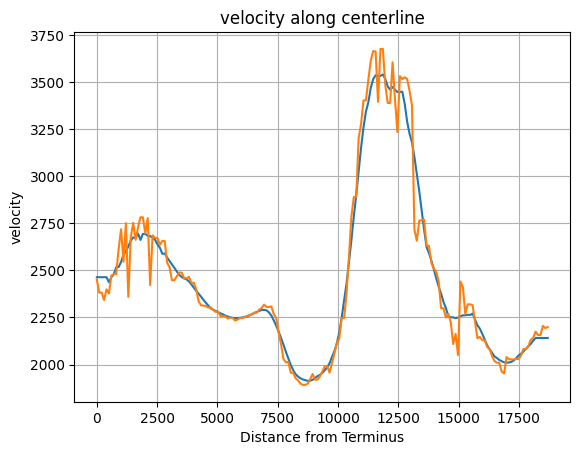

In [78]:
plt.plot(d, v_smooth)
plt.plot(d, v)
plt.xlabel('Distance from Terminus')
plt.ylabel('velocity')
plt.title('velocity along centerline')
plt.grid(True)
plt.show()

In [79]:
g = 9.81
rhoi = 917
rhow = 1000
H = surfdem_centerline - beddem_centerline
h = surfdem_centerline

# calculate force acting on terminus 
Hf = H[0]
hf= h[0]
Ff = g*rhoi/2*((1-rhow/rhoi)*Hf**2+rhow/rhoi*hf*(2*Hf-hf))

# calculate resulting flow force from velocity cube
A = 24e-25 # (PoG table)
ng = 3     # glens exponent
epsilon0 = dvdx
eta = (2*A*((epsilon0/A)**((ng-1)/ng)))**(-1) 

# driving force
taud = H*dvdx # driving stress
Fd = cumulative_trapezoid(taud, d, initial=0) + Ff

# resulting longitudinal force
net_f = 4 * H * dvdx * eta

#cumulative restisting force
Rf = Fd - net_f 

# spatial resolution of about 1000m (2xice average thickness)
l = np.linspace(0, 100*len(d), 20)

# calculate average resisting force
Rf_avg = np.zeros(len(l))

for i in range(len(l)-1):
    Rf_avg[i] = Rf[i+1] - Rf[i] 

# calculate average driving force
Fd_avg = np.zeros(len(l))

for i in range(len(l)-1):
    Fd_avg[i] = Fd[i+1] - Fd[i] 

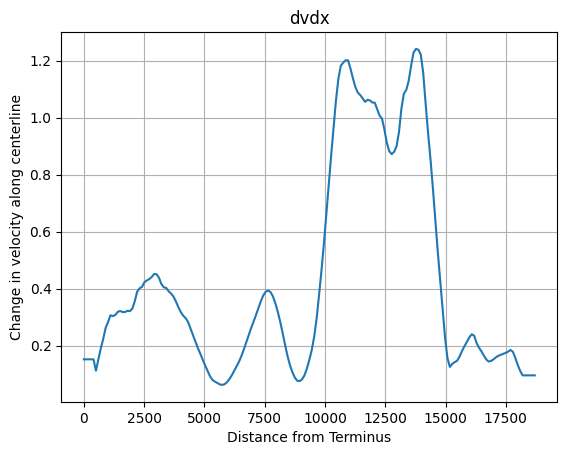

In [80]:
#plt.plot(d, net_f, label='Integral from 0 to x')
plt.plot(d, dvdx, label='Integral from 0 to x')
plt.xlabel('Distance from Terminus')
plt.ylabel('Change in velocity along centerline')
plt.title('dvdx')
plt.grid(True)
plt.show()

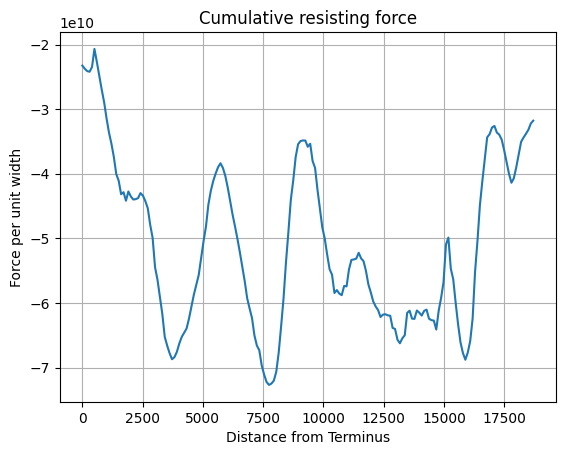

In [81]:
#plt.plot(d, net_f, label='Integral from 0 to x')
plt.plot(d, Rf, label='Integral from 0 to x')
plt.xlabel('Distance from Terminus')
plt.ylabel('Force per unit width')
plt.title('Cumulative resisting force')
plt.grid(True)
plt.show()

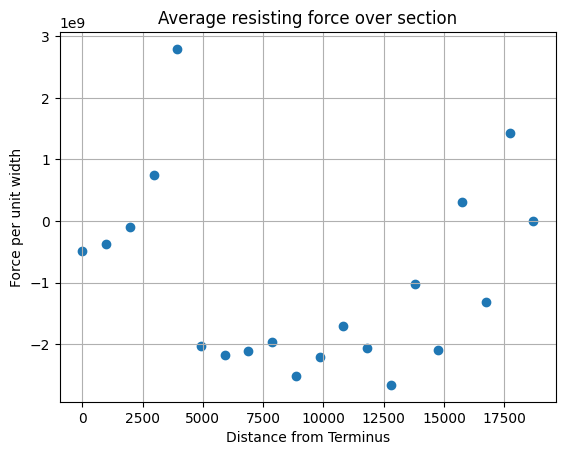

In [82]:
plt.scatter(l, Rf_avg, label='Integral from 0 to x')
plt.xlabel('Distance from Terminus')
plt.ylabel('Force per unit width')
plt.title('Average resisting force over section')
plt.grid(True)
plt.show()

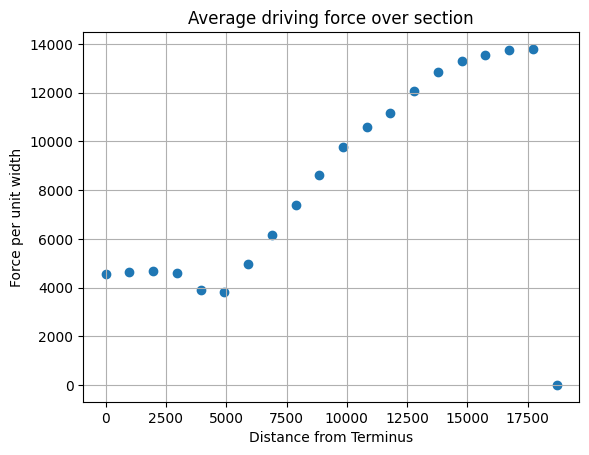

In [83]:
plt.scatter(l, Fd_avg, label='Integral from 0 to x')
plt.xlabel('Distance from Terminus')
plt.ylabel('Force per unit width')
plt.title('Average driving force over section')
plt.grid(True)
plt.show()

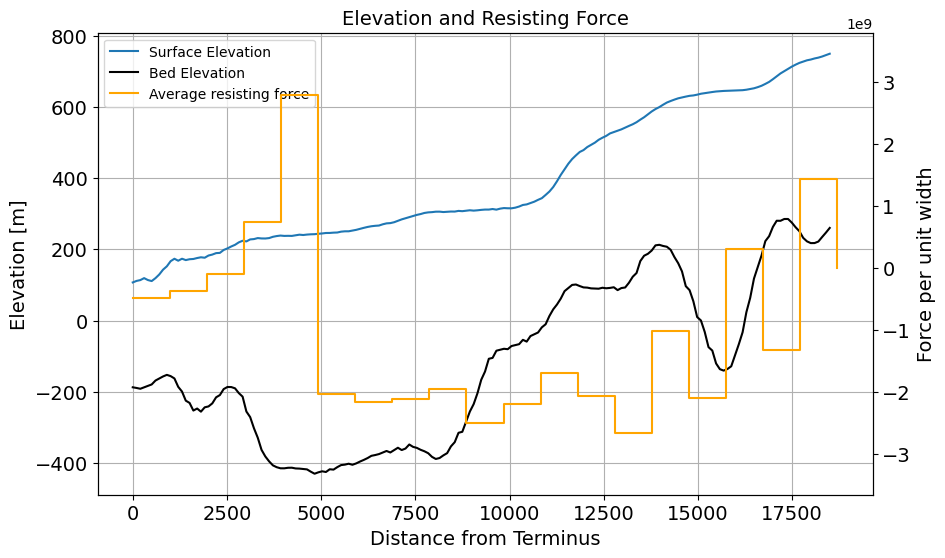

In [84]:
fig, ax1 = plt.subplots(figsize=(10, 6))
fs = 14
l_bar = np.repeat(l, 2)
Rf_avg_bar = np.repeat(Rf_avg, 2)

# Plot the first set of data on ax1
ax1.plot(d[:-2], surfdem_centerline[:-2], label='Surface Elevation')
ax1.plot(d[:-2], beddem_centerline[:-2], label='Bed Elevation', color='black')
ax1.set_xlabel('Distance from Terminus', fontsize=fs)
ax1.set_ylabel('Elevation [m]', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

# Create a twin axis for the second plot
ax2 = ax1.twinx()

# Plot the second set of data on ax2
ax2.plot(l_bar[1:], Rf_avg_bar[:-1], label='Average resisting force', color='orange')
ax2.set_ylabel('Force per unit width', fontsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_ylim(np.min(Rf_avg)-1e9, np.max(Rf_avg)+1e9)  # Example limits; adjust as needed

# Adding titles and grid
plt.title('Elevation and Resisting Force', fontsize=fs)
ax1.grid(True)

# Adding legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.show()


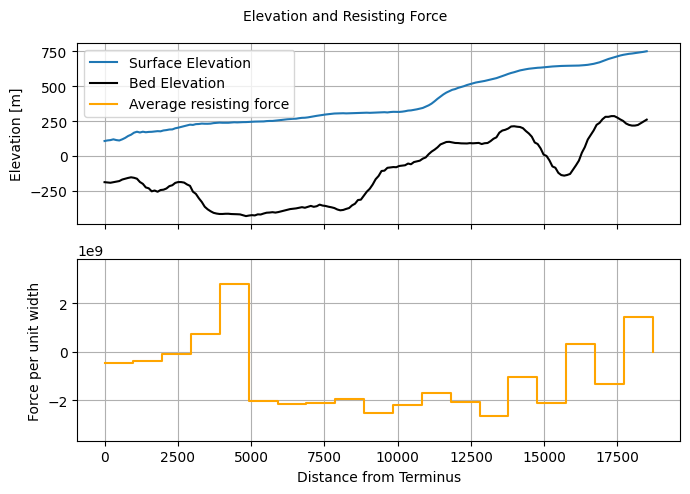

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,5), sharex=True, tight_layout=True)

fs = 10

# Plot the first set of data on ax1
ax1.plot(d[:-2], surfdem_centerline[:-2], label='Surface Elevation')
ax1.plot(d[:-2], beddem_centerline[:-2], label='Bed Elevation', color='black')
ax1.set_ylabel('Elevation [m]', fontsize=fs)
ax1.tick_params(axis='both', which='major', labelsize=fs)

# Plot the second set of data on ax2
l_bar = np.repeat(l, 2)
Rf_avg_bar = np.repeat(Rf_avg, 2)
ax2.plot(l_bar[1:], Rf_avg_bar[:-1], label='Average resisting force', color='orange')
ax2.set_xlabel('Distance from Terminus', fontsize=fs)
ax2.set_ylabel('Force per unit width', fontsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)
ax2.set_ylim(np.min(Rf_avg)-1e9, np.max(Rf_avg)+1e9)  # Example limits; adjust as needed

# Adding titles and grid
plt.suptitle('Elevation and Resisting Force', fontsize=fs)
ax1.grid(True)
ax2.grid(True)

# Adding legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')
plt.show()